### 0.1 READ THE DATA SOURCE

In [27]:
import configparser

# Initiate the configparser
config = configparser.ConfigParser()

# Read the config ini file
config.read('config.ini')

# Access the file path
csv_file_path = config['path']['startup_growth']

### 0.2 DEFINE HTML DISPLAY

In [30]:
from IPython.display import display, HTML
import pandas as pd

# Define the CSS that will make the table scrollable
css = """
.output {
    max-height: 500px; /* Adjust as needed */
    overflow: scroll;  /* Allows scrolling */
}
"""

# Apply the CSS for scrollable output
display(HTML('<style>{}</style>'.format(css)))

# Configure pandas display options for better visuals
pd.set_option('display.max_rows', None)  # Display all rows, adjust as needed
pd.set_option('display.max_columns', None)  # Display all columns, adjust as needed
pd.set_option('display.max_colwidth', 90)  # Set max column width for long text
pd.options.display.float_format = '{:,.2f}'.format  # Format floating-point numbers


_______
### 1. DATA EXPOSURE

In [31]:
# Read the csv file
startup_data = pd.read_csv(csv_file_path, encoding='UTF-8-SIG')


# Function to display table with data types
def display_data(df, title):
    shape_info = f"<div><b>Shape:</b> {df.shape}</div>" # Shape information
    summary_stats = df.describe().to_html() # Summary statistics
    data_types = df.dtypes.to_frame().to_html() # Data types disclosure
    
    # Display title, table, data types, summary statistics, and complete dataset
    display(HTML(f"<h2>{title}</h2>"))
    display(HTML(shape_info))
    display(HTML(f"<div><b>Data Types:</b></div>"))
    display(HTML(data_types))
    display(HTML(f"<div><b>Summary Statistics:</b></div>"))
    display(HTML(summary_stats))
    display(HTML(f"<div><b>Complete Dataset:</b></div>"))
    display(HTML(df.to_html(index=False)))

# Display the data complete overview
display_data(startup_data, "STARTUP GROWTH & INVESTMENT DATA")


,0
Startup Name,object
Industry,object
Funding Rounds,int64
Investment Amount (USD),float64
Valuation (USD),float64
Number of Investors,int64
Country,object
Year Founded,int64
Growth Rate (%),float64


,Funding Rounds,Investment Amount (USD),Valuation (USD),Number of Investors,Year Founded,Growth Rate (%)
count,"5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00"
mean,5.49,"2,455,567,193.89","7,971,059,089.45",25.54,"2,011.54",102.09
std,2.91,"1,423,787,264.50","5,479,486,954.59",14.27,6.89,56.18
min,1.00,"1,102,610.00","1,722,547.17",1.00,"2,000.00",5.06
25%,3.00,"1,221,506,059.44","3,598,305,232.08",13.00,"2,006.00",52.82
50%,6.00,"2,460,633,712.51","7,002,304,340.71",25.00,"2,012.00",102.22
75%,8.00,"3,639,951,117.50","11,476,757,163.75",38.00,"2,018.00",150.58
max,10.00,"4,999,543,707.18","24,709,061,035.64",50.00,"2,023.00",199.97


Startup Name,Industry,Funding Rounds,Investment Amount (USD),Valuation (USD),Number of Investors,Country,Year Founded,Growth Rate (%)
Startup_1,Blockchain,8,"1,335,165,853.10","6,621,448,041.82",50,Germany,2012,77.10
Startup_2,SaaS,2,"2,781,498,219.93","8,363,214,103.89",36,UK,2006,105.52
Startup_3,EdTech,10,"3,309,031,930.22","15,482,697,353.10",39,Singapore,2016,190.47
Startup_4,Fintech,5,"4,050,196,269.12","12,682,527,892.18",44,France,2021,9.44
Startup_5,EdTech,9,"1,645,080,294.64","6,887,965,942.87",48,India,2011,192.00
Startup_6,EdTech,3,"3,939,088,574.84","11,462,969,525.30",38,Singapore,2003,26.28
Startup_7,HealthTech,8,"1,349,245,127.85","2,490,393,546.17",24,India,2017,104.98
Startup_8,Blockchain,7,"4,128,951,425.92","16,303,568,856.29",24,India,2006,89.13
Startup_9,Blockchain,3,"3,950,045,010.91","9,733,266,249.00",5,Brazil,2007,57.99
Startup_10,Fintech,10,"4,865,378,632.80","18,692,791,832.25",31,USA,2000,31.16


#### 1.1 DATA OVERVIEW

- **Startup Name** Unique Identifier, and the name of the company/startup that recieved the founding.
- **Industry** The economical sector which the startup operates.
- **Founding Rounds** The total of rounds a startup has gone through.
- **Investment Amount** The total amount of founding recieved in USD from venture.
- **Valuation (USD)** The estimated valuation of the startup after recieving founding.
- **Number of Investors** Shareholder count.
- **Country** The country where the startup is headquartered or primaly operates.
- **Year Founded** The year when the startup was established.
- **Growth Rate** The annual growth rate of the startup, expressed as a percentage.

### 2. DATA MANIPULATION TO EXTRACT INSIGHTS

#### 2.1 WHAT IS THE RELATIONSHIP BETWEEN THE INVESTMENT AMOUNT AND VALUATION ACROSS INDUSTRIES AND COUNTRIES?

In [57]:
# Step 1: Group by Industry and summarize Valuation and Investment Amount per year
industry_summary = startup_data.groupby(['Industry', 'Year Founded']).agg({
    'Valuation (USD)': 'sum',
    'Investment Amount (USD)': 'sum'
}).reset_index()

# Step 2: Group by Country and summarize Valuation and Investment Amount per year
country_summary = startup_data.groupby(['Country', 'Year Founded']).agg({
    'Valuation (USD)': 'sum',
    'Investment Amount (USD)': 'sum'
}).reset_index()

# Step 3: Calculate Investment-to-Valuation Ratio for both DataFrames
industry_summary['Investment-to-Valuation Ratio'] = industry_summary['Valuation (USD)'] / industry_summary['Investment Amount (USD)']
country_summary['Investment-to-Valuation Ratio'] = country_summary['Valuation (USD)'] / country_summary['Investment Amount (USD)']

# Step 4: Calculate mean Investment-to-Valuation Ratio for each industry and country
industry_mean = industry_summary.groupby('Industry')['Investment-to-Valuation Ratio'].mean().reset_index()
country_mean = country_summary.groupby('Country')['Investment-to-Valuation Ratio'].mean().reset_index()

# Step 5: Filter top and bottom 3 industries and countries
top_industries = industry_mean.nlargest(1, 'Investment-to-Valuation Ratio')['Industry']
bottom_industries = industry_mean.nsmallest(1, 'Investment-to-Valuation Ratio')['Industry']
top_countries = country_mean.nlargest(1, 'Investment-to-Valuation Ratio')['Country']
bottom_countries = country_mean.nsmallest(1, 'Investment-to-Valuation Ratio')['Country']

# Step 6: Display historical mean in HTML format
# Industry Mean
html_industry_mean = industry_mean.to_html(index=False)
display(HTML("<h2>Historical Mean Investment-to-Valuation Ratio by Industry</h2>"))
display(HTML(html_industry_mean))

# Country Mean
html_country_mean = country_mean.to_html(index=False)
display(HTML("<h2>Historical Mean Investment-to-Valuation Ratio by Country</h2>"))
display(HTML(html_country_mean))

# Filter the industry and country summaries
filtered_industry_summary = industry_summary[industry_summary['Industry'].isin(top_industries)| industry_summary['Industry'].isin(bottom_industries)]
filtered_country_summary = country_summary[country_summary['Country'].isin(top_countries)| country_summary['Country'].isin(bottom_countries)]



# Step : Display the filtered tables in HTML format
html_filtered_industry = filtered_industry_summary.to_html(index=False)
html_filtered_country = filtered_country_summary.to_html(index=False)

display(HTML("<h2>Filtered Industry Summary</h2>"))
display(HTML(html_filtered_industry))

display(HTML("<h2>Filtered Country Summary</h2>"))
display(HTML(html_filtered_country))

Industry,Investment-to-Valuation Ratio
AI,3.32
Biotech,3.27
Blockchain,3.22
E-commerce,3.27
EdTech,3.24
Fintech,3.22
HealthTech,3.13
SaaS,3.25


Country,Investment-to-Valuation Ratio
Australia,3.31
Brazil,3.23
Canada,3.23
China,3.33
France,3.23
Germany,3.24
India,3.26
Singapore,3.25
UK,3.19
USA,3.21


Industry,Year Founded,Valuation (USD),Investment Amount (USD),Investment-to-Valuation Ratio
AI,2000,"197,902,544,242.10","56,344,027,727.29",3.51
AI,2001,"264,128,433,230.16","72,388,488,598.09",3.65
AI,2002,"157,538,804,829.16","52,628,751,128.34",2.99
AI,2003,"262,955,265,238.01","70,093,271,855.29",3.75
AI,2004,"123,853,291,497.13","42,291,258,264.00",2.93
AI,2005,"104,557,463,884.56","32,647,624,141.56",3.20
AI,2006,"219,667,366,736.25","66,171,544,120.88",3.32
AI,2007,"282,505,354,640.19","73,491,802,218.46",3.84
AI,2008,"176,876,973,502.70","58,169,462,257.33",3.04
AI,2009,"253,687,536,657.89","69,632,546,098.33",3.64


Country,Year Founded,Valuation (USD),Investment Amount (USD),Investment-to-Valuation Ratio
China,2000,"212,988,861,521.07","69,912,994,461.88",3.05
China,2001,"180,729,114,369.93","55,204,977,677.62",3.27
China,2002,"162,673,778,410.36","50,192,264,151.60",3.24
China,2003,"176,599,294,127.15","53,912,109,307.16",3.28
China,2004,"107,915,174,397.63","31,986,031,618.29",3.37
China,2005,"167,712,600,246.88","56,225,719,279.13",2.98
China,2006,"92,694,323,647.05","30,943,226,857.22",3.00
China,2007,"146,092,013,172.03","42,264,271,265.41",3.46
China,2008,"218,329,838,657.08","67,022,935,459.79",3.26
China,2009,"228,846,167,974.23","63,719,305,831.36",3.59


### 3. VISUALIZATIONS 

#### 3.1. VISUALIZE THE INVESTMENT-TO-VALUATION RATIO PER COUNTRY AND INDUSTRY

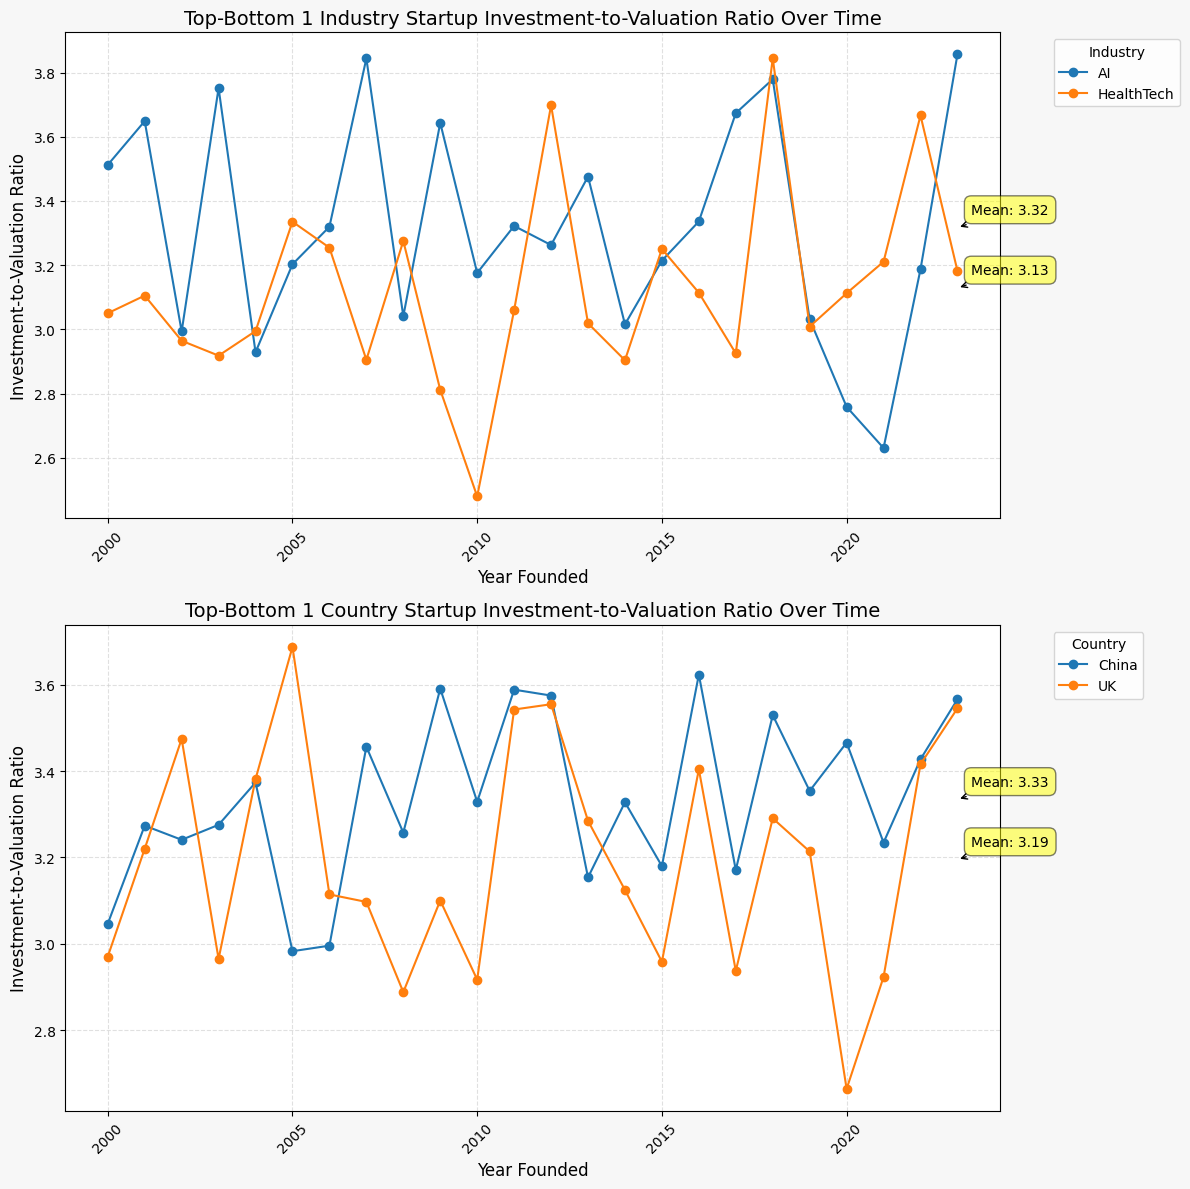

In [60]:
import matplotlib.pyplot as plt

# Create visualizations
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
fig.patch.set_facecolor('#f7f7f7')

# Plot for Filtered Industry Summary
for industry, group in filtered_industry_summary.groupby('Industry'):
    ax1.plot(group['Year Founded'], group['Investment-to-Valuation Ratio'], label=industry, marker='o')
    # Add floating box with historical mean
    mean_value = industry_mean[industry_mean['Industry'] == industry]['Investment-to-Valuation Ratio'].values[0]
    ax1.annotate(f'Mean: {mean_value:.2f}', 
                 xy=(group['Year Founded'].max(), mean_value), 
                 xytext=(10, 10), textcoords='offset points',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

ax1.set_title('Top-Bottom 1 Industry Startup Investment-to-Valuation Ratio Over Time', fontsize=14)
ax1.set_xlabel('Year Founded', fontsize=12)
ax1.set_ylabel('Investment-to-Valuation Ratio', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7, color='lightgray')
ax1.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.tick_params(axis='x', rotation=45)
ax1.set_facecolor('#ffffff')

# Plot for Filtered Country Summary
for country, group in filtered_country_summary.groupby('Country'):
    ax2.plot(group['Year Founded'], group['Investment-to-Valuation Ratio'], label=country, marker='o')
    # Add floating box with historical mean
    mean_value = country_mean[country_mean['Country'] == country]['Investment-to-Valuation Ratio'].values[0]
    ax2.annotate(f'Mean: {mean_value:.2f}', 
                 xy=(group['Year Founded'].max(), mean_value), 
                 xytext=(10, 10), textcoords='offset points',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

ax2.set_title('Top-Bottom 1 Country Startup Investment-to-Valuation Ratio Over Time', fontsize=14)
ax2.set_xlabel('Year Founded', fontsize=12)
ax2.set_ylabel('Investment-to-Valuation Ratio', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.7, color='lightgray')
ax2.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.tick_params(axis='x', rotation=45)
ax2.set_facecolor('#ffffff')

plt.tight_layout()
plt.savefig('filtered_investment_valuation_ratio_visualization_with_mean_box.png', dpi=300, bbox_inches='tight')
plt.show()